In [24]:
# import dependencies
import pandas as pd
import numpy as np
import csv
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
fake_news_df = pd.read_csv("/content/fake_news.csv")
display(fake_news_df)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [27]:
# check missing values in dataset
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [28]:
# replace NaN values in 'title' and 'text' with 'missing'
fake_news_df['title'].fillna('missing', inplace=True)
fake_news_df['text'].fillna('missing', inplace=True)

# replace NaN values in 'author' with 'unknown'
fake_news_df['author'].fillna('unknown', inplace=True)

1    10413
0    10387
Name: label, dtype: int64


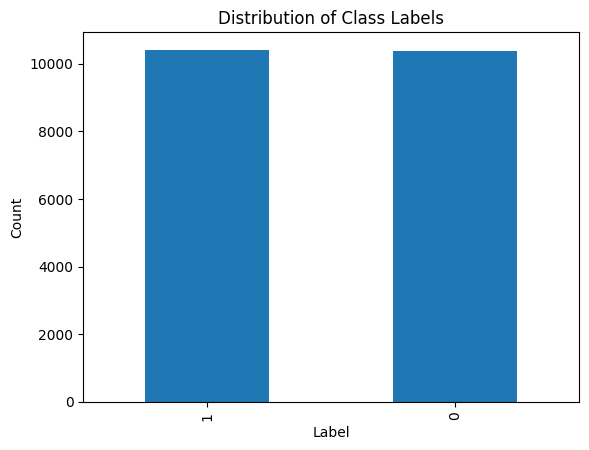

In [29]:
# check the distribution of the class labels
label_count = fake_news_df["label"].value_counts()
print(label_count)

label_count.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()


To make any models we have to use either text column or combination of author and title columns. Due to large paragraphs in text columns we would try this option as well.

**Merging author and title columns**

In [30]:
fake_news_df['content'] = fake_news_df['author']+' '+fake_news_df['title']

In [31]:
fake_news_df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [32]:
#Seperate data and target (label)

X = fake_news_df.drop('label', axis=1)
y = fake_news_df['label']


In [33]:
print(X)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

In [34]:
print(y)

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20800, dtype: int64


**Stemming: reduce words to their root**

In [35]:
import nltk
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords

In [36]:
#insignificant words
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [38]:
port_stem = PorterStemmer()

In [39]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]+',' ', content) #include only alphabets (all numbers and punctuations will be removed)
  stemmed_content = stemmed_content.lower() #convert all alphabets into lower case
  stemmed_content = stemmed_content.split() #split and convert to list
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  #stem all the words that are not in stopwords
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [40]:
#apply stemming function to content column
fake_news_df['content'] = fake_news_df['content'].apply(stemming)

In [41]:
print(fake_news_df['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


There is only lower case words in content column now

In [42]:
fake_news_df

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,darrel lucu hous dem aid even see comey letter...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,daniel j flynn flynn hillari clinton big woman...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,consortiumnew com truth might get fire
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,jessica purkiss civilian kill singl us airstri...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,howard portnoy iranian woman jail fiction unpu...
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,jerom hudson rapper trump poster child white s...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,benjamin hoffman n f l playoff schedul matchup...
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,michael j de la merc rachel abram maci said re...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,alex ansari nato russia hold parallel exercis ...


In [46]:
#seperate x and y
X = fake_news_df['content'].values
y = fake_news_df['label'].values

In [49]:
print(X)
X.shape

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


(20800,)

In [50]:
print(y)
y.shape

[1 0 1 ... 0 1 1]


(20800,)

convert all the texts into numbers using TfidfVectorizer package

In [51]:
vectorizer=TfidfVectorizer()
vectorizer.fit(X)

TfidfVectorizer()

In [52]:
X=vectorizer.transform(X)

In [53]:
print(X)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

Split data into train and test 80/20

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)